In [2]:
from deep_dating.networks import DatingCNN
from deep_dating.datasets import DatingDataLoader, DatasetName, SetType
from deep_dating.metrics import DatingMetrics
from deep_dating.util import SEED, save_figure
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
import pickle

In [2]:
model = DatingCNN()
model.load_state_dict(torch.load("runs/Dec21-16-31-47/model_epoch_8.pt"))
model.base_model.fc = nn.Identity()
model.eval()

DatingCNN(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05,

In [3]:
# val_loader = DatingDataLoader(DatasetName.MPS, SetType.VAL, model)

# all_outputs = []
# all_labels = []

# with torch.no_grad():
#     for inputs, labels in tqdm(val_loader):

#         labels = labels.unsqueeze(1)
#         all_labels.append(labels)
        
#         outputs = model(inputs)
#         all_outputs.append(outputs)

In [4]:
# all_outputs_np = np.concatenate(all_outputs)
# print(all_outputs_np.shape)
# np.save("feat_val.npy", all_outputs_np, allow_pickle=True)

# all_labels_np = np.concatenate(all_labels)
# print(all_labels_np.shape)
# np.save("feat_labels_val.npy", all_labels_np, allow_pickle=True)

In [2]:
features = np.load("../experimental/feat_val.npy", allow_pickle=True)
labels = np.load("../experimental/feat_labels_val.npy", allow_pickle=True).astype(int).flatten()

In [10]:
with open("runs/Feb15-19-21-40_new/model_epoch_0_feats_val.pkl", "rb") as f:
    labels, features, all_paths = pickle.load(f)
    labels = labels.flatten()

In [4]:
features.shape

(19251, 2048)

In [22]:
%matplotlib ipympl

In [12]:
unique_labels = list(np.unique(labels))
num_unique_labels = len(unique_labels)
print(f"{num_unique_labels} unique labels:", unique_labels)
colors = sns.color_palette('Spectral', n_colors=num_unique_labels)

15 unique labels: [1000.0, 1050.0, 1150.0, 1225.0, 1275.0, 1325.0, 1375.0, 1413.0, 1438.0, 1463.0, 1488.0, 1513.0, 1538.0, 1563.0, 1588.0]


In [23]:
def get_date_dict(reduced_features):
    dict_ = {}

    for i, x in enumerate(labels):
        val = reduced_features[i, :]
        if x not in dict_:
            dict_[x] = [val]
        else:
            dict_[x].append(val)

    for key in dict_.keys():
        dict_[key] = np.vstack(dict_[key])

    return dict_

def plot_dims(reduced_features, axs_name, title_text, in_3d=False):
    dict_ = get_date_dict(reduced_features)
    keys = sorted(dict_.keys())
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111, projection="3d") if in_3d else plt.gca()

    for i, key in enumerate(keys):
        arr = dict_[key]
        z = arr[:, 2] if in_3d else None
        ax.scatter(arr[:, 0], arr[:, 1], z, color=colors[i], label=str(key))

    fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5), title="Date")
    plt.xlabel(axs_name + " 1")
    plt.ylabel(axs_name + " 2")
    if in_3d:
        ax.set_zlabel(axs_name + " 3")
    plt.title(title_text)
    title_text = title_text.lower().replace(" ", "_") + str("_3d" if in_3d else "")
    save_figure(title_text, show=True)

## PCA

In [19]:
pca = PCA(n_components=features.shape[1], random_state=SEED)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_pca = pca.fit_transform(features)

First 10 components: [24.286816  23.632986   9.739162   8.2483225  4.5768676  3.5549066
  2.8408432  2.4677355  2.149734   1.8490318]


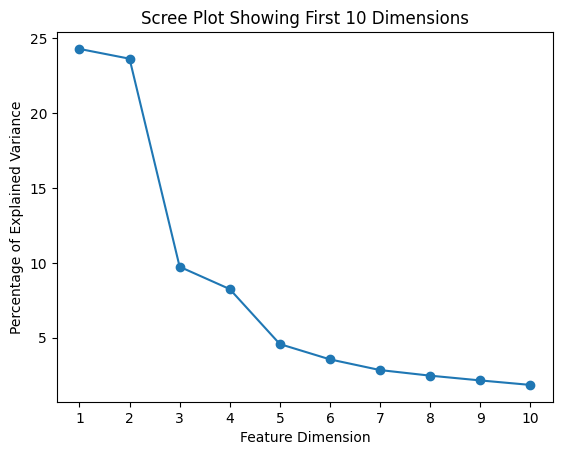

In [20]:
n = 10
x = np.arange(1, pca.n_components_ + 1)[:n]
var_explained = (pca.explained_variance_ratio_ * 100)[:n]
plt.plot(x, var_explained, "o-")
print("First", n, "components:", var_explained)
plt.xticks(x)
plt.xlabel("Feature Dimension")
plt.ylabel("Percentage of Explained Variance")
plt.title(f"Scree Plot Showing First {n} Dimensions")
plt.show()

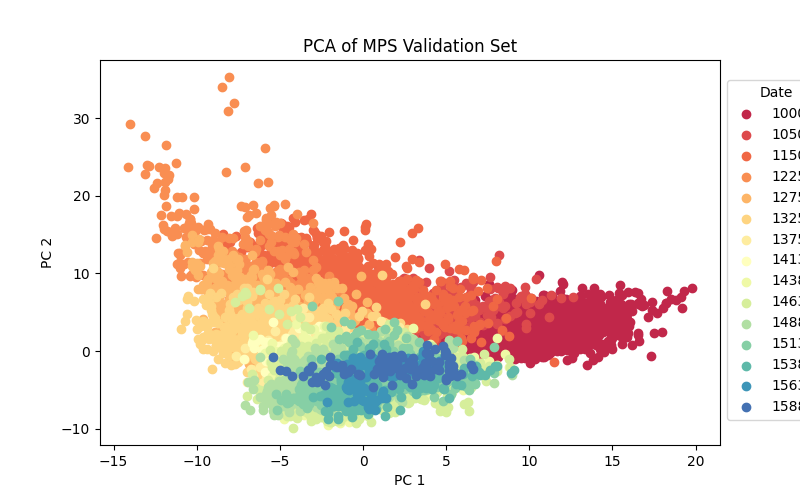

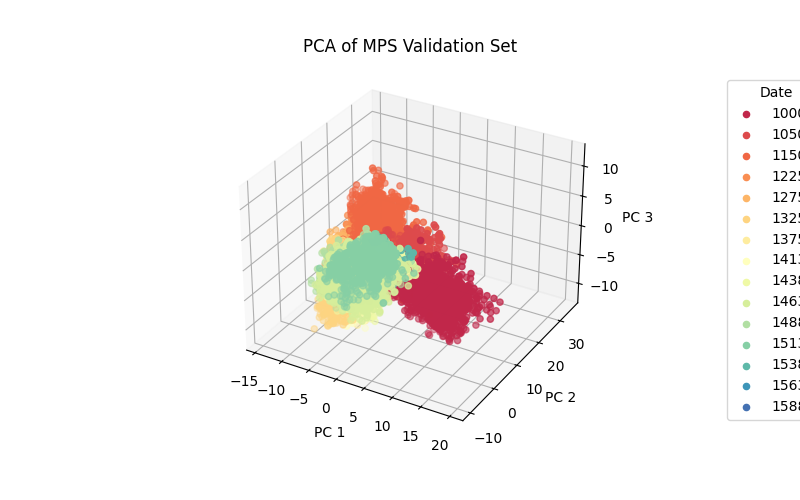

In [24]:
pca_title = "PCA of MPS Validation Set"
plot_dims(features_pca, "PC", pca_title)
plot_dims(features_pca, "PC", pca_title, in_3d=True)

## TSNE

In [17]:
perplexity=30
tsne_2d = TSNE(n_components=2, perplexity=perplexity, random_state=SEED, n_jobs=-1)
features_tsne_2d = tsne_2d.fit_transform(features)
tsne_3d = TSNE(n_components=3, perplexity=perplexity, random_state=SEED, n_jobs=-1)
features_tsne_3d = tsne_3d.fit_transform(features)

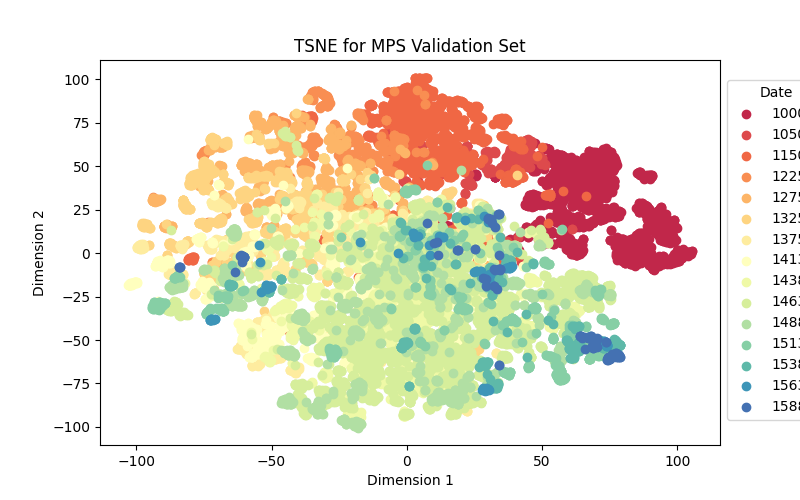

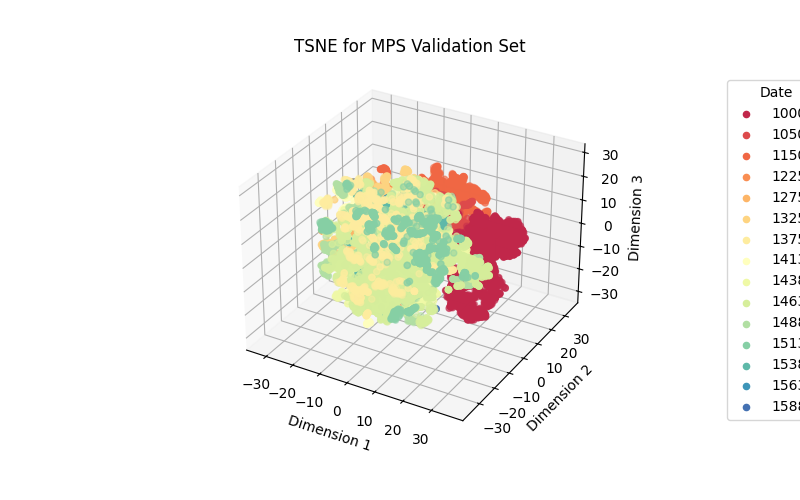

In [25]:
tsne_title = "TSNE for MPS Validation Set"
plot_dims(features_tsne_2d, "Dimension", tsne_title)
plot_dims(features_tsne_3d, "Dimension", tsne_title, in_3d=True)

## SVM

In [26]:
train_feat, test_feat, train_labels, test_labels = train_test_split(features, labels, test_size=0.3, random_state=SEED)

In [27]:
print(train_feat.shape)
svm = SVR(kernel="rbf")
svm.fit(train_feat, train_labels)

(11368, 1536)


SVR()

In [28]:
predict = svm.predict(test_feat)

In [29]:
alphas = np.arange(0, 51)
metrics = DatingMetrics(alphas=alphas)
metrics.names

dict_keys(['mae', 'mse', 'cs_0', 'cs_1', 'cs_2', 'cs_3', 'cs_4', 'cs_5', 'cs_6', 'cs_7', 'cs_8', 'cs_9', 'cs_10', 'cs_11', 'cs_12', 'cs_13', 'cs_14', 'cs_15', 'cs_16', 'cs_17', 'cs_18', 'cs_19', 'cs_20', 'cs_21', 'cs_22', 'cs_23', 'cs_24', 'cs_25', 'cs_26', 'cs_27', 'cs_28', 'cs_29', 'cs_30', 'cs_31', 'cs_32', 'cs_33', 'cs_34', 'cs_35', 'cs_36', 'cs_37', 'cs_38', 'cs_39', 'cs_40', 'cs_41', 'cs_42', 'cs_43', 'cs_44', 'cs_45', 'cs_46', 'cs_47', 'cs_48', 'cs_49', 'cs_50'])

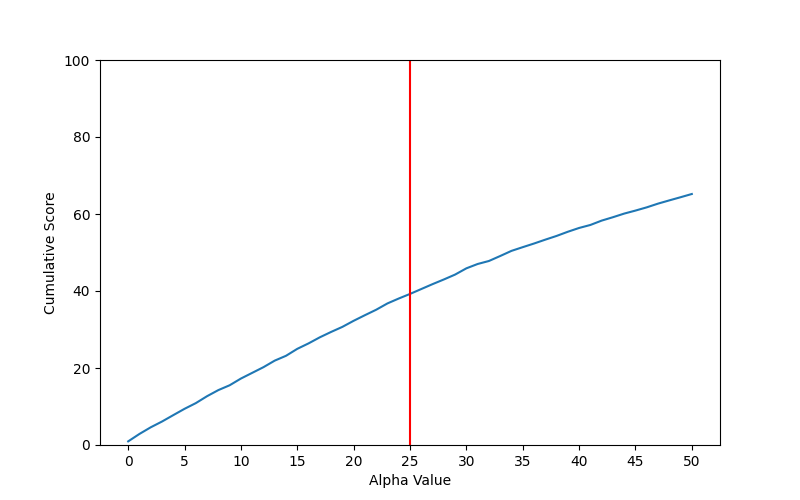

In [31]:
vals = metrics.calc(test_labels, predict)

mae, mse = tuple(vals[:2])
cs_ = vals[2:]

plt.cla()
plt.clf()
plt.plot(alphas, cs_)
plt.xlabel("Alpha Value")
plt.ylabel("Cumulative Score")
plt.ylim(0, 100)
plt.xticks(np.arange(0, 55, 5))
plt.axvline(x=25, color="red")
plt.show()